# train $\mathcal{Q}_T(X)$ to estimate covariate support for treated sample

In [1]:
import os, glob
import numpy as np
import astropy.table as aTable
from tqdm.notebook import tqdm, trange

In [2]:
import copy
import torch
from nflows import transforms, distributions, flows
from torch import optim

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [13]:
treat_data = np.load('../dat/fema_crs.treat.train.npy')

Ntrain = int(0.9 * treat_data.shape[0])
itests = np.random.choice(np.arange(treat_data.shape[0]), size=treat_data.shape[0] - Ntrain, replace=False)
is_test = np.zeros(treat_data.shape[0]).astype(bool)
is_test[itests] = True

train_x = treat_data[:,1:]

ndim = train_x.shape[1]
train_loader = torch.utils.data.DataLoader(
        torch.tensor(train_x[~is_test].astype(np.float32)).to(device), 
        batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(
        torch.tensor(train_x[is_test].astype(np.float32)).to(device), 
        batch_size=512, shuffle=False)

122x3


  0%|          | 0/1000 [00:00<?, ?it/s]

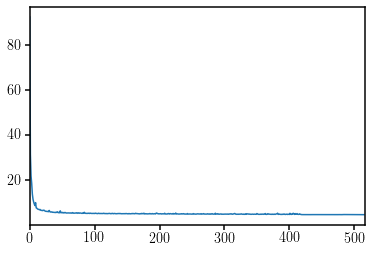

88x4


  0%|          | 0/1000 [00:00<?, ?it/s]

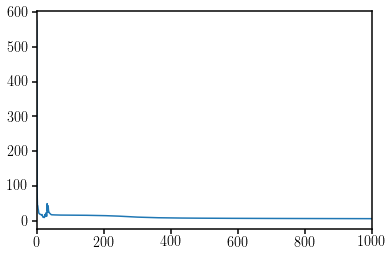

95x5


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


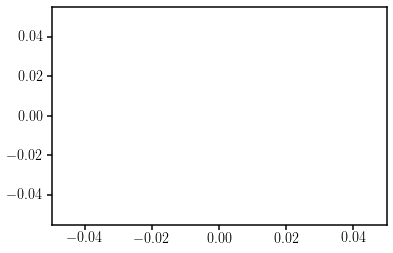

87x3


  0%|          | 0/1000 [00:00<?, ?it/s]

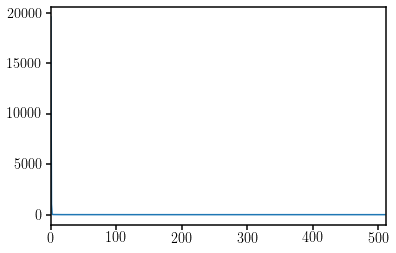

105x5


  0%|          | 0/1000 [00:00<?, ?it/s]

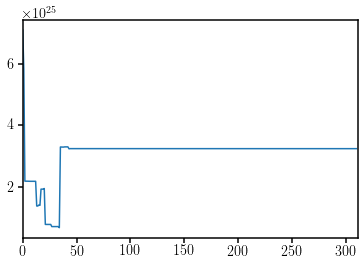

In [18]:
num_iter = 1000
patience = 20
lrate   = 1e-3

all_flows, all_archs, all_valid_losses = [], [], []
for i in range(5): 
    nhidden = int(np.ceil(np.random.uniform(64, 128)))
    nblocks = int(np.random.uniform(3, 7))
    print('%ix%i' % (nhidden, nblocks))
    blocks = []
    for iblock in range(nblocks): 
        blocks += [transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
                transforms.RandomPermutation(features=ndim)]
    transform = transforms.CompositeTransform(blocks)

    base_distribution = distributions.StandardNormal(shape=[ndim])
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    flow.to(device)

    optimizer = optim.Adam(flow.parameters(), lr=lrate)
    scheduler = scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, min_lr=1e-5)
    #optim.lr_scheduler.OneCycleLR(optimizer, lrate, total_steps=num_iter)

    best_epoch, best_valid_loss, valid_losses = 0, np.inf, []
    t = trange(num_iter, leave=False)
    for epoch in t:
        train_loss = 0.
        for batch in train_loader: 
            optimizer.zero_grad()
            loss = -flow.log_prob(batch).mean()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_loss = train_loss/float(len(train_loader))

        with torch.no_grad():
            valid_loss = 0.
            for batch in valid_loader: 
                loss = -flow.log_prob(batch).mean()
                valid_loss += loss.item()
            valid_loss = valid_loss/len(valid_loader)
            if np.isnan(valid_loss): break
            valid_losses.append(valid_loss)
        scheduler.step(valid_loss)

        t.set_description('Epoch: %i LR %.2e TRAINING Loss: %.2e VALIDATION Loss: %.2e' % 
                          (epoch, scheduler._last_lr[0], train_loss, valid_loss), refresh=False)            
            
        if scheduler._last_lr[0] == 1e-5: 
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
                best_flow = copy.deepcopy(flow)
            else: 
                if epoch > best_epoch + patience: 
                    break 
                    
    plt.plot(np.arange(len(valid_losses)), valid_losses)
    plt.xlim(0, len(valid_losses))
    plt.show()
    
    all_archs.append('%ix%i' % (nhidden, nblocks))
    all_flows.append(best_flow)
    all_valid_losses.append(valid_losses)

In [19]:
_losses = []
for vl in all_valid_losses:
    if len(vl) > 0: _losses.append(np.nanmin(vl))
    else: _losses.append(np.inf)
ibest = np.nanargmin(_losses)

best_flow = all_flows[ibest]
best_arch = all_archs[ibest]

torch.save(best_flow, '../dat/qphi_support.v2.log.treat.pt')

# validate $\mathcal{Q}_T(X)$ against $p_T(X)$

In [20]:
nde_covar = best_flow.sample(10000)

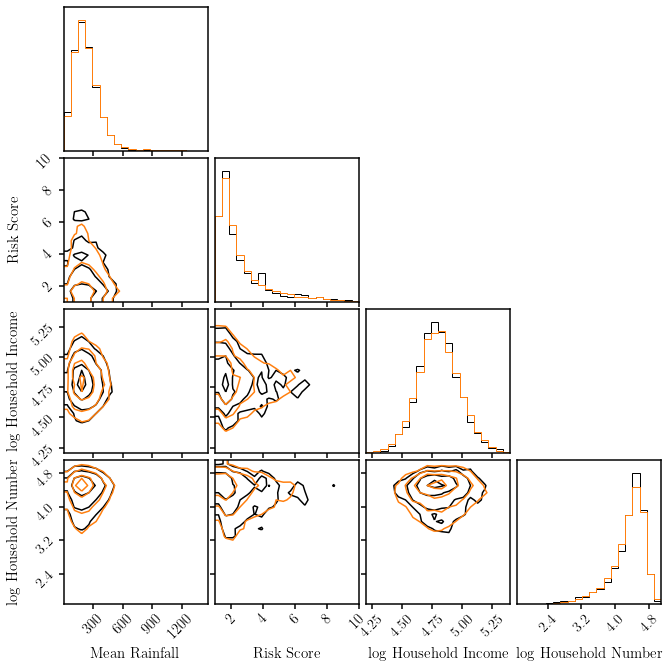

In [27]:
fig = DFM.corner(treat_data[:,1:], color='k', hist_kwargs={'density': True}, 
                 labels=['Mean Rainfall', 'Risk Score', 'log Household Income', 'log Household Number'],
                 label_kwargs={'fontsize': 15}, plot_datapoints=False, plot_density=False, smooth=False)
fig = DFM.corner(np.array(nde_covar.detach().cpu()), color='C1', hist_kwargs={'density': True}, 
                 range=[(np.min(col), np.max(col)) for col in treat_data[:,1:].T],
                 labels=['Mean Rainfall', 'Risk Score', 'log Household Income', 'log Household Number'],
                 label_kwargs={'fontsize': 15}, plot_datapoints=False, plot_density=False, smooth=False, fig=fig)